### Resources

#### UKF using GRPs & Quats by Markley & Crassidis: http://www.acsu.buffalo.edu/~johnc/uf_att.pdf
#### UKF using GRPs & Quats by LVL: https://ascelibrary.org/doi/10.1061/%28ASCE%29AS.1943-5525.0000718

### Import dependencies

In [1]:
from PyAstronomy import pyasl
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy.spatial.transform import Rotation as Rot
from filterpy.kalman import UnscentedKalmanFilter as UKF, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
from pyquaternion import Quaternion
import matplotlib.mlab as mlab
from scipy.stats import norm

from numpy.linalg import pinv, inv

import tqdm

from utils import *
import config as c

plt.style.use('plot_style.txt')

device cpu




In [2]:
def q2grp(q, a, f, wfirst=False):
    return f*(q[:3])/(a+q[3])
def grp2q(x, a, f):
    x_norm_sqrd = np.linalg.norm(x[:3])**2
    scalar = (-a*x_norm_sqrd + f*np.sqrt(f**2+(1-a**2)*x_norm_sqrd))/(f**2+x_norm_sqrd)
    vector = (f**-1) * (a + scalar) * x[:3]
    q = np.zeros(4)
    q[:3] = vector
    q[3] = scalar
    
    #q = q / np.linalg.norm(q)
    return q
def qinv(q):
    qi = np.zeros(4)
    qi[:3] = -q[:3]
    qi[3] = q[3]
    return qi
def quatmul(qc, qd):
    return qMatrix(qc) @ qd
def calc_mean(y, n, lam):
    # y shape: (n, sigmadots)
    return 1 / (n + lam) * (lam * y[:, 0] + 0.5 * y[:, 1:].sum(1))
def calcP(y, y_mean, c, c_mean, n, lam, sigmadots):
    P_sum_i = np.array([calc_cov(y[:, i], y_mean, c[:, i], c_mean) for i in range(1,sigmadots)]).sum(0)
    P_sum_0 = calc_cov(y[:, 0], y_mean, c[:, 0], c_mean)
    return 1 / (n + lam) * (lam *  P_sum_0 + 0.5 * P_sum_i)
def qMatrix(q):
    x, y, z, w = q
    A = np.array([[w, z, -y, x], 
                  [-z, w, x, y], 
                  [y, -x, w, z], 
                  [-x, -y, -z, w]])
    return A
def calc_cov(a, b, c, d):
    # calculate [a - b][c - d]^T
    # a, b, c, d are all (m,1)
    a = a.reshape((a.shape[0], 1))
    b = b.reshape((b.shape[0], 1))
    c = c.reshape((c.shape[0], 1))
    d = d.reshape((d.shape[0], 1))
    return ((a - b) @ (c - d).transpose())

def quat_update(dt, omega, q):
    
    alphadelta = np.linalg.norm(omega) * dt
    edelta = omega / np.linalg.norm(omega)
    
    qdelta = np.zeros(4)
    qdelta[:3] = edelta * np.sin(alphadelta/2)
    qdelta[3] = np.cos(alphadelta / 2)
    
    return quatmul(q, qdelta)

def quatdiff(q1, q2):
    return quatmul(q1, qinv(q2))

def hx(x, a_const, f_const):
    return grp2q(x[:3], a_const, f_const)


In [3]:
a_const = 1
f_const = 2*(a_const + 1)
seq_len = 100
ts = np.linspace(0,4,seq_len)
dt = ts[0] - ts[1]
eulers = np.array([np.sin(ts), np.sin(ts), np.sin(ts)]).transpose()
dth = np.array([np.cos(ts), np.cos(ts), np.cos(ts)]).transpose()
q_gt =  np.array([Rot.from_euler('xyz', x).as_quat() for x in eulers])
z_q = np.array([Rot.from_euler('xyz', x + np.random.randn(3)*1e-2).as_quat() for x in eulers])
z_grp = np.zeros((seq_len, 3))
for k in range(seq_len):
    z_grp[k] = q2grp(z_q[k],a_const,f_const)

In [4]:
tracks = [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7][::1]
#lamtracks = list(range(-10,10))

#for trackl in lamtracks:
trackQ = 1e-5
trackR = 1e-5
#for trackR in tracks:
#trackR = 1e-4

#for  in tracks:

#print(trackR, trackQ)

dimx = n = 6
dimz = 3
lam = 0

# initial conditions
X = np.zeros(dimx) # state = [dp, omega]
X[3:] = dth[0]
P = np.eye(dimx) * 1e-5 # initial uncertainty
Q = np.eye(dimx) * trackQ
R = np.eye(dimz) * trackR

# stored variables for reporting.
xhat = np.zeros((seq_len, dimx))
xhat[0] = X
qhat = np.zeros((seq_len, 4))
qhat[0] = z_q[0]
q = qhat[0]
Ps = np.zeros((seq_len, dimx, dimx))
Ps[0] = P

for t in tqdm.tqdm(range(1,seq_len)):
    Reff = R
    # have q
    X[:3] = np.zeros(3)
    omega = X[3:]

    # Creating Sigma Pts. -- eq 5
    L = np.linalg.cholesky((n + lam) * (P + Q))
    sig = np.concatenate((-L.diagonal(), L.diagonal())).flatten().transpose()
    sigmadots = len(sig)

    chi = np.zeros((6,sigmadots))
    for i in range(sigmadots):
        chi[:3,i] = sig[i] + X[:3] # eq 33

    delta_q = np.zeros((4, sigmadots))
    delta_q[:, 0] = np.array([0,0,0,1])
    for i in range(1,sigmadots):
        delta_q[:, i] = grp2q(chi[:3, i], a_const, f_const) # eq 32

    sq = np.zeros((4,sigmadots))
    sq[:,0] = q
    for i in range(1,sigmadots):
        sq[:,i] = quatmul(delta_q[:,i], q) # eq 35

    est_omega = omega
    pred_q = np.zeros((4, sigmadots)) # set of propagated quaternions at time "t"
    for i in range(sigmadots):
        pred_q[:,i] = quat_update(dt, est_omega[:], sq[:,i]) # eq 34

    pred_delta_q = np.zeros((4,sigmadots))
    for i in range(sigmadots):
        pred_delta_q[:,i] = quatmul(pred_q[:,i], qinv(pred_q[:, 0])) # eq 36

    chi[:3, 0] = np.zeros(3)
    for i in range(1,sigmadots):
        chi[:3, i] = q2grp(pred_delta_q[:, i], a_const, f_const) # eq 37

    pred_mean = calc_mean(chi, n, lam) # eq 7, expected dp    
    Pxx = calcP(chi, pred_mean, chi, pred_mean, n, lam, sigmadots) + Q # eq 8
    #####################
    qtilde = z_q[t]
    # measurement residual / innovation
    dq_res = np.zeros((4, sigmadots))
    for i in range(sigmadots):
        dq_res[:, i] = quatmul(qtilde, qinv(pred_q[:, i])) # eq 40 in Lee
    # convert measurement residual to grps
    dp_res = np.zeros((3, sigmadots))
    for i in range(sigmadots):
        dp_res[:, i] = q2grp(dq_res[:, i], a_const, f_const) # eq 40 in Lee
    # eq 41 in Lee
    zcov0 = dp_res[:dimz, 0].reshape((dimz,1)) @ dp_res[:dimz, 0].reshape((dimz,1)).transpose()
    zcovsum = np.zeros((dimz,dimz))
    for i in range(1, sigmadots):
        zcovsum_i = dp_res[:dimz, i].reshape((dimz,1)) @ dp_res[:dimz, i].reshape((dimz,1)).transpose()
        zcovsum += zcovsum_i
    Pzz = 1 / (n + lam) * (lam * zcov0 + 0.5 * zcovsum)
    # eq 42 in Lee
    xzcov0 = (chi[:, 0] - pred_mean[:]).reshape((dimx,1)) @ dp_res[:dimz, 0].reshape((dimz,1)).transpose()
    xzcovsum = np.zeros((dimx,dimz))
    for i in range(1, sigmadots):
        xzcovsum_i = (chi[:, i] - pred_mean[:]).reshape((dimx,1)) @ dp_res[:dimz, i].reshape((dimz,1)).transpose()
        xzcovsum += xzcovsum_i
    Pxz = 1 / (n + lam) * (lam * xzcov0 + 0.5 * xzcovsum)



    #####################    
    #dp_res = np.zeros((3, sigmadots))
    #for i in range(sigmadots):
    #    dp_res[:, i] = q2grp(dq_res[:3, i], a_const, f_const)

    #e =  #averageQuaternions(dq_res.transpose())#quatavg(dq_res)

    Pvv = Pzz + Reff # eq 12
    K = Pxz @ np.linalg.inv(Pvv) # eq 4
    X[:3] = calc_mean(dp_res, n, lam) #pred_mean + K @ e # eq 2a
    P = Pxx - K @ Pvv @ K.transpose() # eq 2b

    #####################
    # update s.c. attitude (quaternion) estimate
    opt_delta_q = grp2q(X[:3], a_const, f_const) # eq 45
    q = quatmul(opt_delta_q, pred_q[:, 0]) # eq 44
    # store for records
    qhat[t] = q
    xhat[t] = X
    Ps[t] = P

    # reset state
    X[:3] = np.zeros(3)
    X[3:] = omega


100%|██████████| 99/99 [00:00<00:00, 497.25it/s]


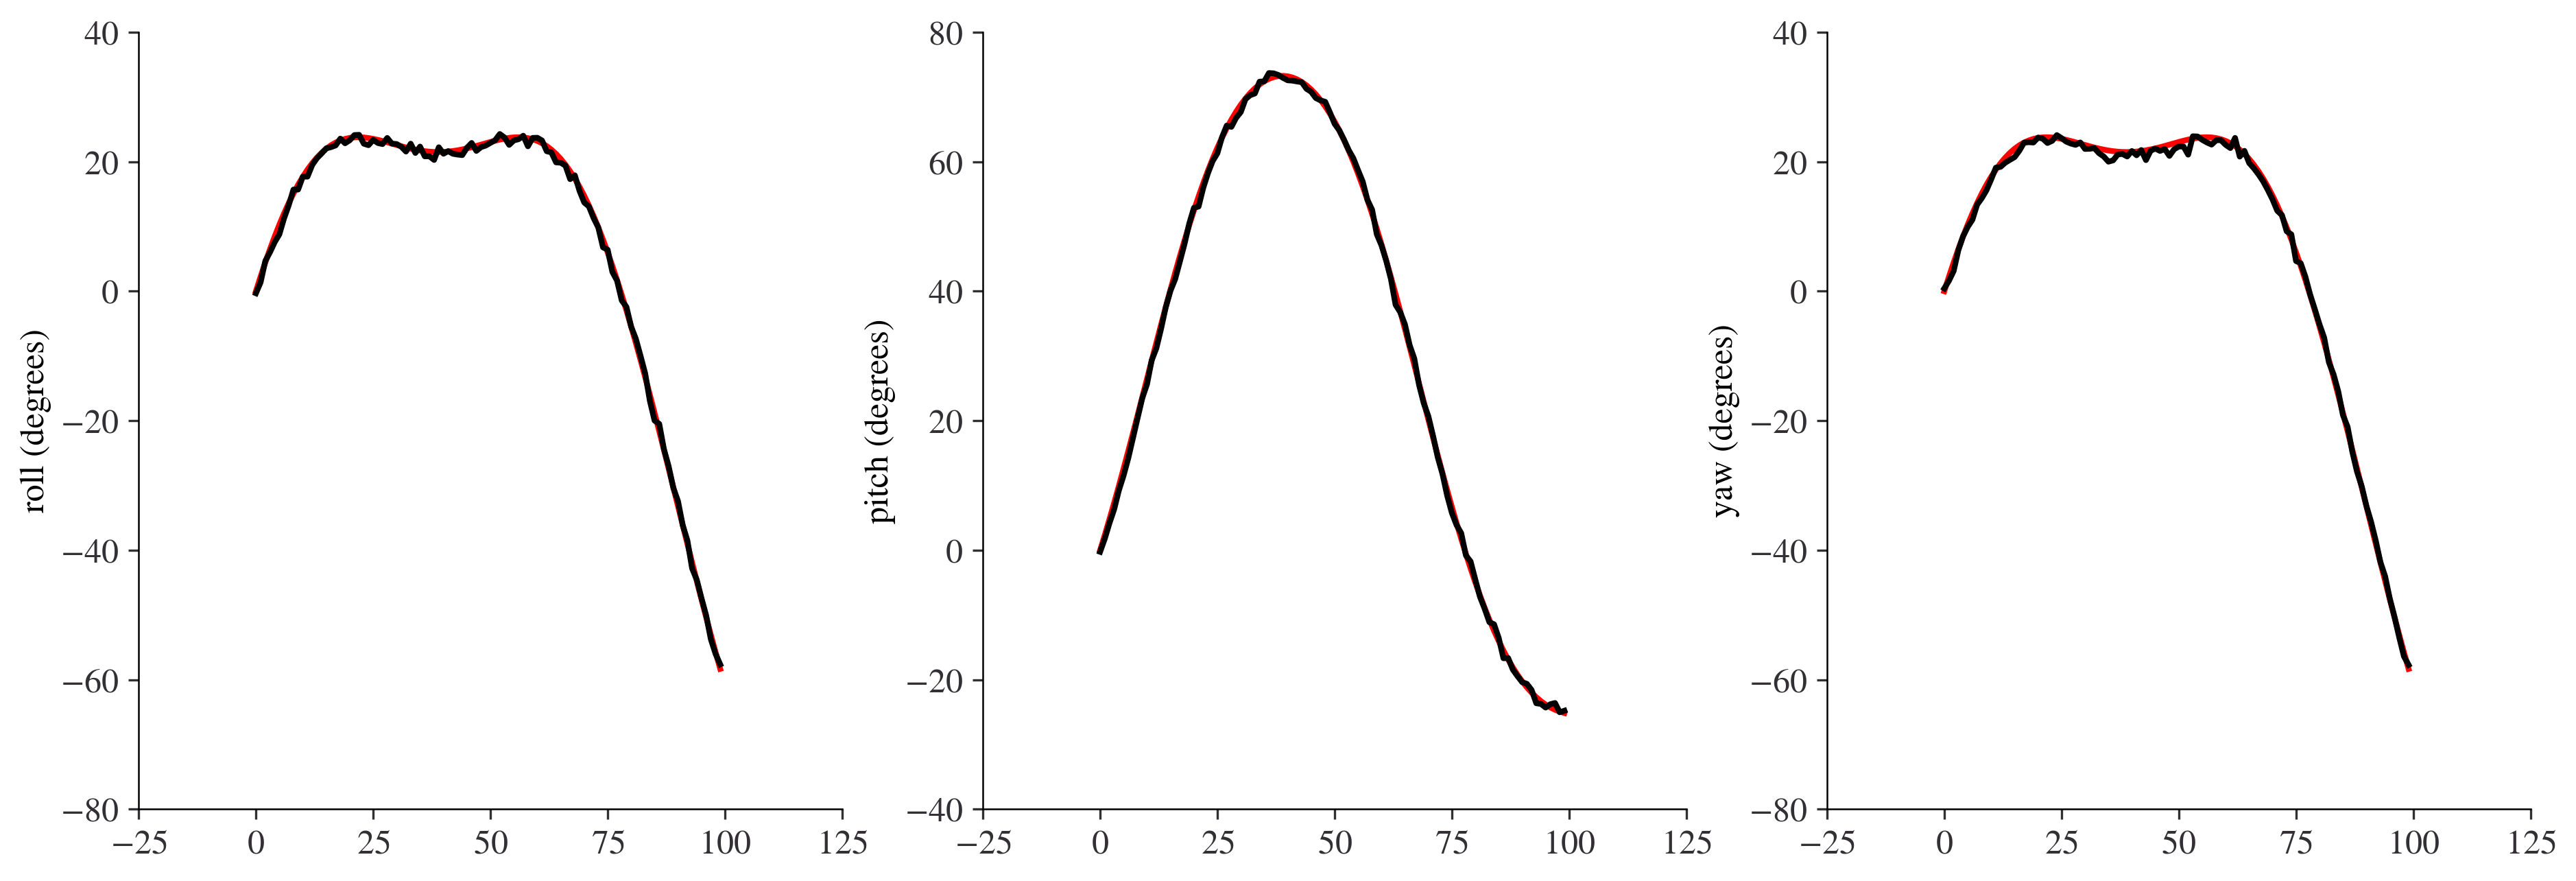

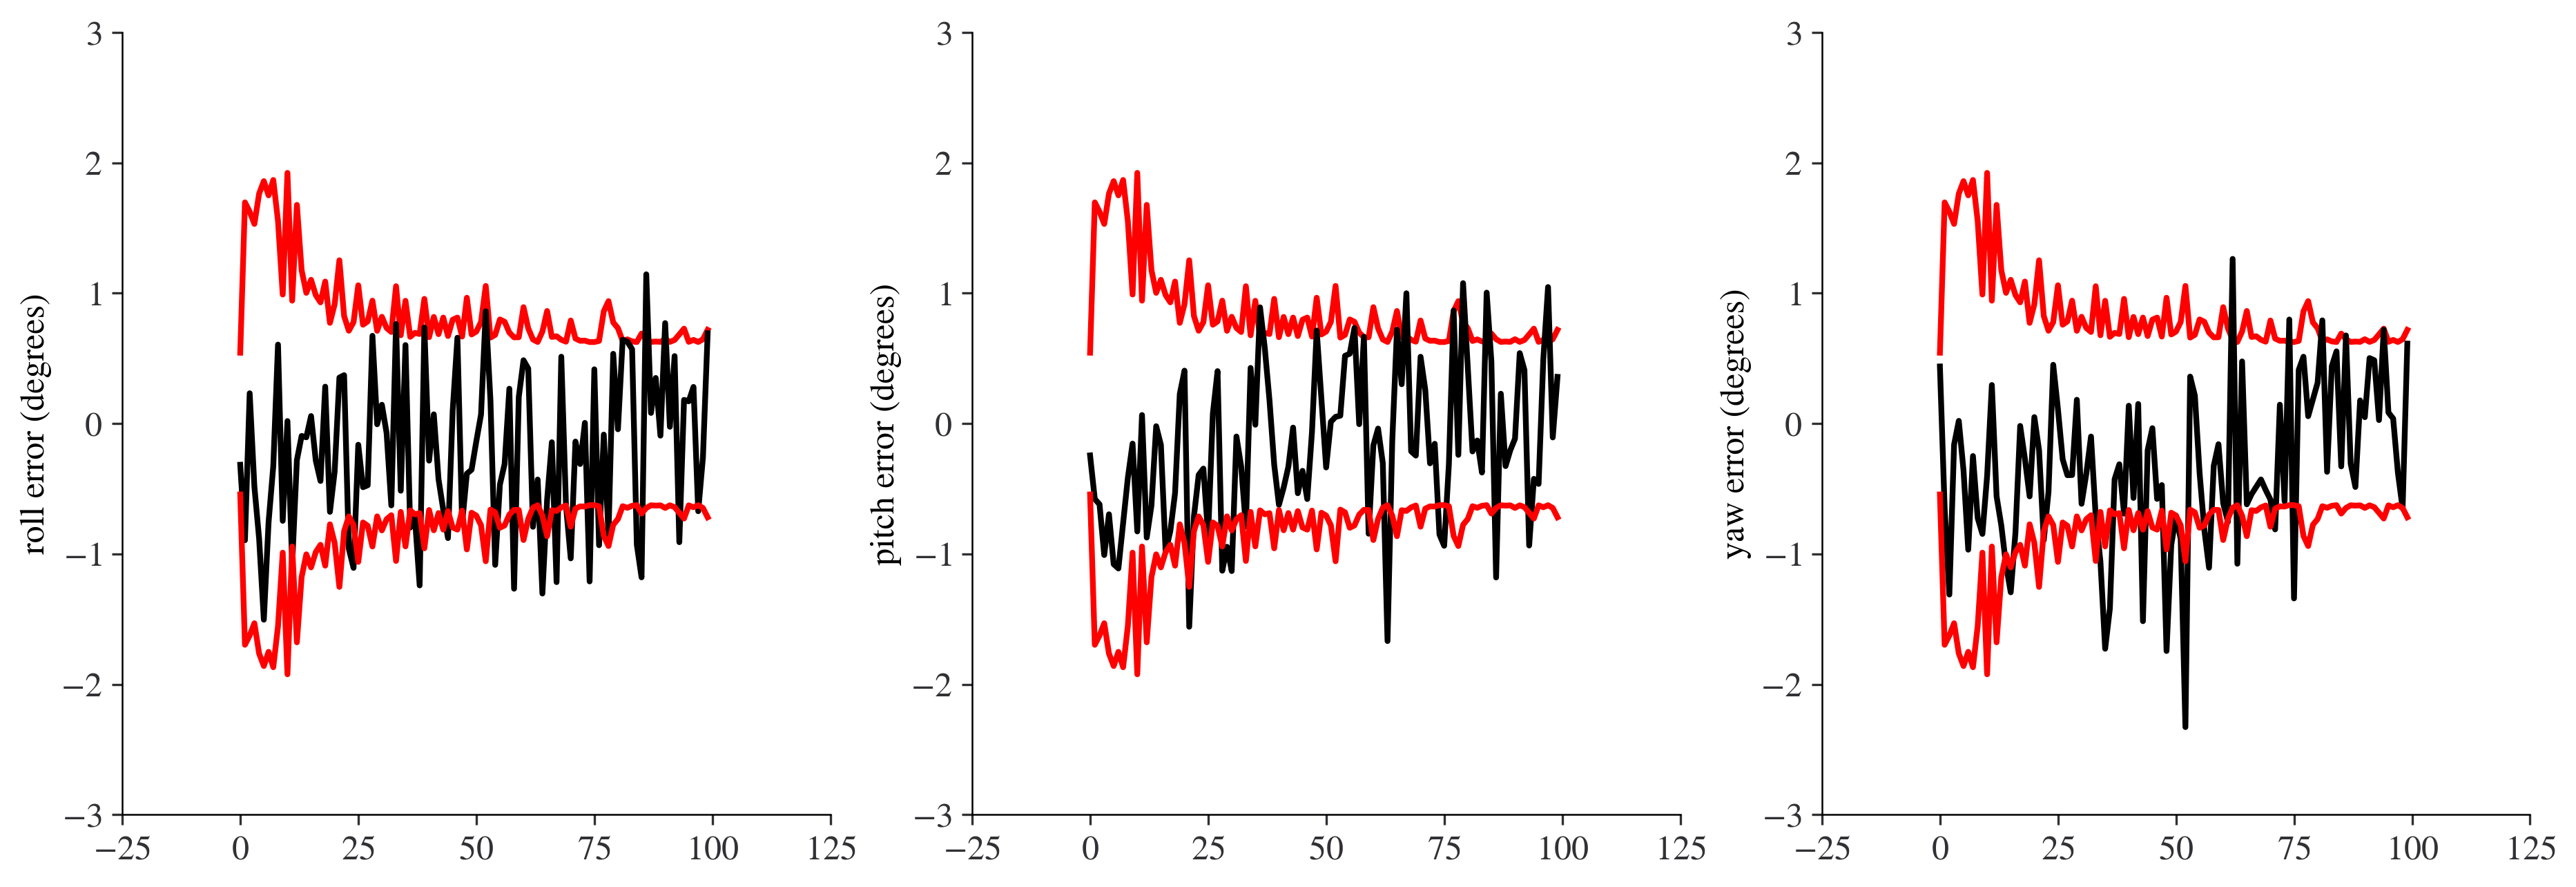

In [5]:
z_e = z_grp
e_gt = np.array([q2grp(x[:4], a_const, f_const) for x in q_gt])
ehat = np.array([q2grp(x[:4], a_const, f_const) for x in qhat])
sig = np.array([np.sqrt(x.diagonal()[:3]) for x in Ps])

e_gt = np.rad2deg(e_gt)
ehat = np.rad2deg(ehat)
sig = np.rad2deg(sig)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))

ax1.plot(e_gt[:,0], c='r')
ax1.plot(ehat[:,0], c='k')
ax1.set_ylabel('roll (degrees)')

ax2.plot(e_gt[:,1], c='r')
ax2.plot(ehat[:,1], c='k')
ax2.set_ylabel('pitch (degrees)')

ax3.plot(e_gt[:,2], c='r')
ax3.plot(ehat[:,2], c='k')
ax3.set_ylabel('yaw (degrees)')

plt.show()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))
error = (ehat - e_gt)
sigmul = 3

ax1.plot(sig[:,0]*sigmul, c='r')
ax1.plot(error[:,0], c='k')
ax1.plot(-sig[:,0]*sigmul, c='r')
ax1.set_ylabel('roll error (degrees)')

ax2.plot(sig[:,1]*sigmul, c='r')
ax2.plot(error[:,1], c='k')
ax2.plot(-sig[:,1]*sigmul, c='r')
ax2.set_ylabel('pitch error (degrees)')

ax3.plot(sig[:,2]*sigmul, c='r')
ax3.plot(error[:,2], c='k')
ax3.plot(-sig[:,2]*sigmul, c='r')
ax3.set_ylabel('yaw error (degrees)')

plt.show()

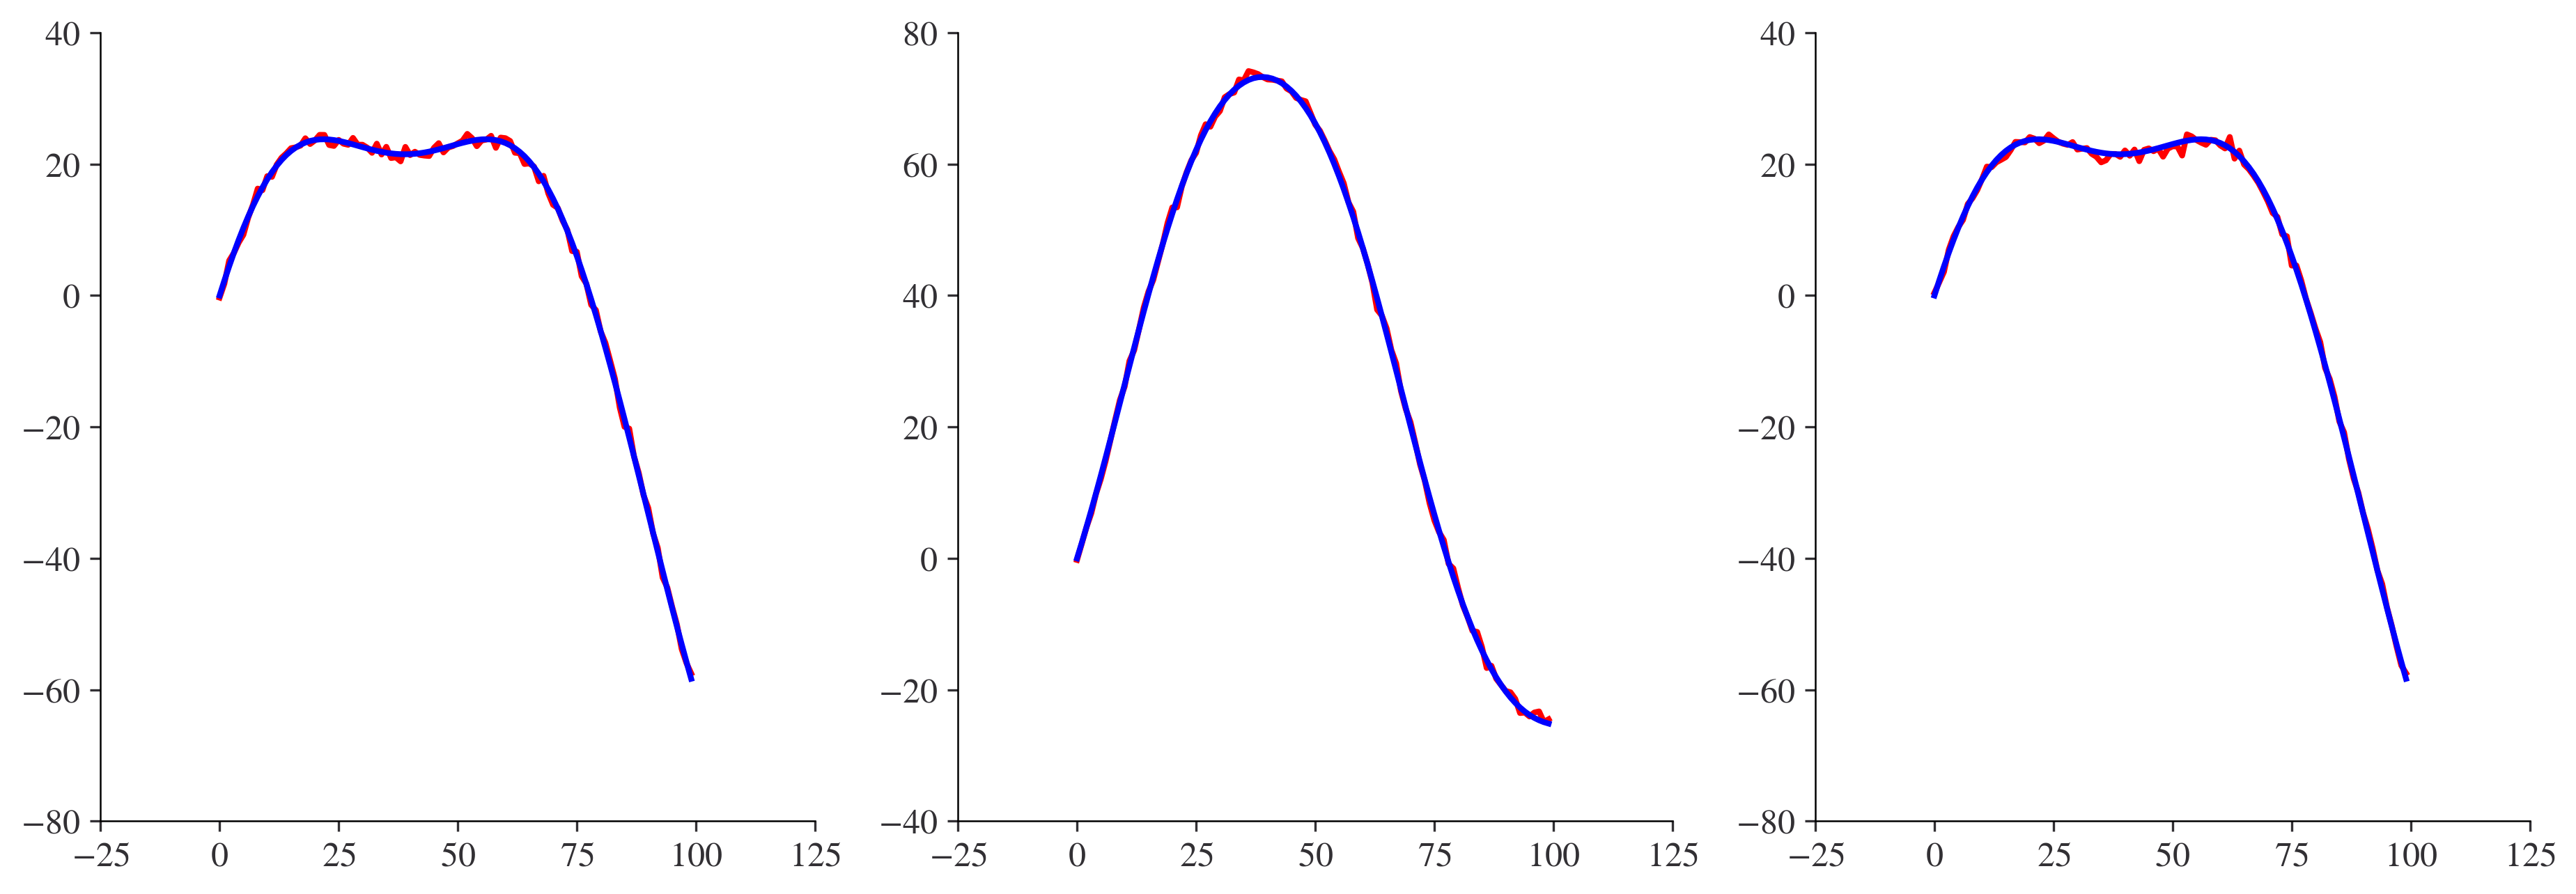

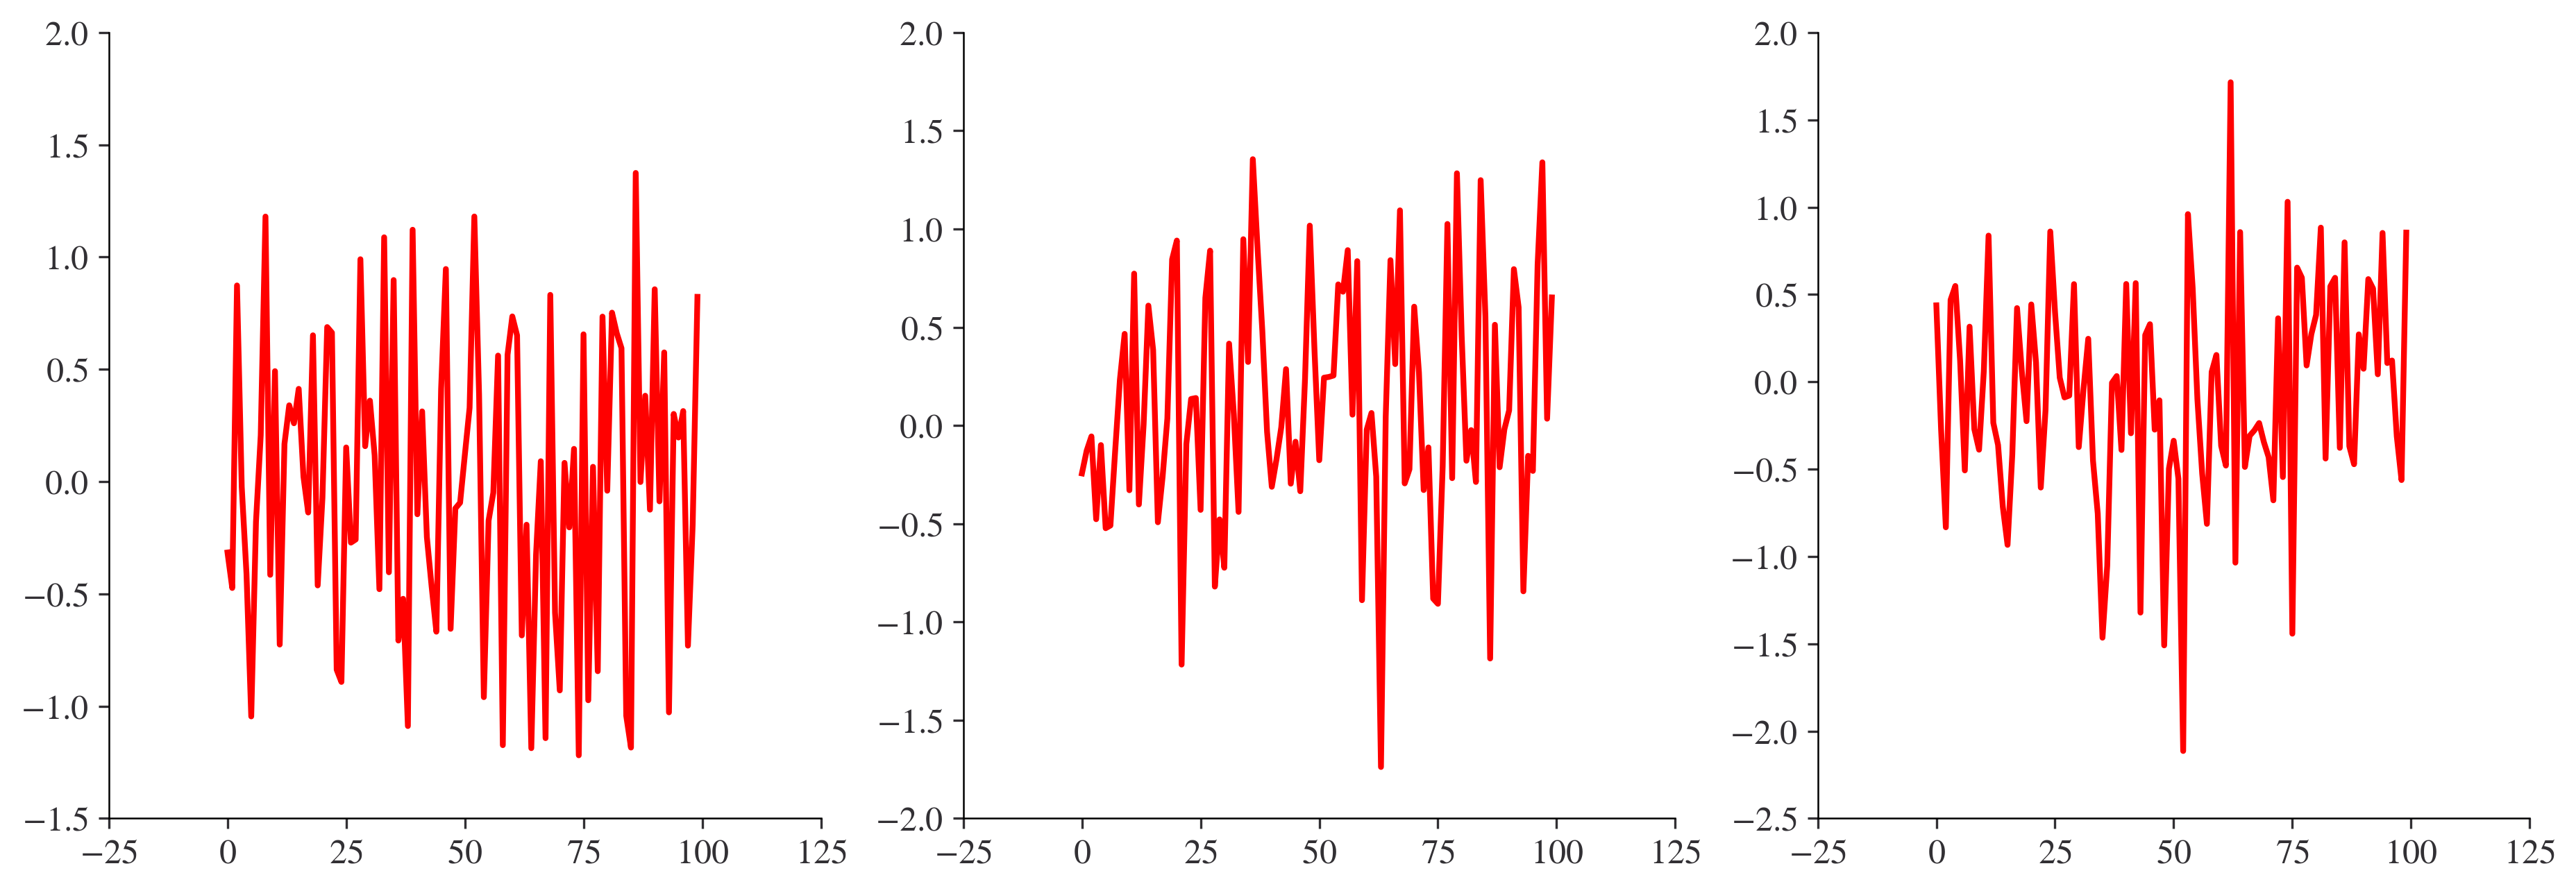

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))

z_grp_ = np.rad2deg(np.array([q2grp(x[:4], a_const, f_const, False) for x in z_q]))

ax1.plot(z_grp_[:,0], c='r',)
ax1.plot(e_gt[:,0], c='b')

ax2.plot(z_grp_[:,1], c='r',)
ax2.plot(e_gt[:,1], c='b')

ax3.plot(z_grp_[:,2], c='r')
ax3.plot(e_gt[:,2], c='b')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))

error = z_grp_ - e_gt
ax1.plot(error[:,0], c='r')
ax2.plot(error[:,1], c='r')
ax3.plot(error[:,2], c='r')

plt.show()

In [7]:
sig[-1] * 3

array([0.71864287, 0.71864287, 0.71864287])